# CSI4142 - Fundamentals of Data Science Assignment 2  

## *Data Cleaning*  

**Professor**: Caroline Barrière  
**Students**: Mohamed-Obay Alshaer & Samih Karroum  
**Student Numbers**: 300170489 & 300188957  
**Submission Date**: February 25th, 2025  
**Group Number**: 39  

---  

## Assignment Overview  

This notebook implements a **Clean Data Checker**, designed to validate the integrity and quality of a dataset by identifying common data issues. The checker performs **10 different validation tests**, each targeting a specific type of potential error:  

1. **Data Type Errors** – Ensuring values match their expected data types.  
2. **Range Errors** – Checking if numerical values fall within an expected range.  
3. **Format Errors** – Validating that data follows a specific format (e.g., dates, IDs).  
4. **Consistency Errors** – Identifying conflicting or contradictory values.  
5. **Uniqueness Errors** – Verifying attributes that should have unique values.  
6. **Presence Errors** – Detecting missing values in required fields.  
7. **Length Errors** – Checking if text values meet length constraints.  
8. **Look-up Errors** – Ensuring categorical values exist in a predefined list.  
9. **Exact Duplicate Errors** – Detecting completely duplicated rows.  
10. **Near Duplicate Errors** – Identifying rows that are very similar but not identical.  

Each test is structured into **four parts**:  

1. **Error Description** – Explanation of the type of error being checked.  
2. **Parameter Definition** – A cell where users can define validation rules.  
3. **Validation Code** – The logic that performs the check based on provided parameters.  
4. **Results Report** – A summary of detected issues with examples.  

---  

## Dataset Description  

The dataset used in this notebook contains **records of real estate transactions in New York City** over a **12-month period**. Each row represents a **building or building unit sale** and includes information such as location, address, property type, sale price, and sale date.  

### **Key Fields**  
- **BOROUGH** – Encoded as a digit (1–5) representing different NYC boroughs.  
- **BLOCK, LOT** – Together with BOROUGH, these form a unique property identifier.  
- **BUILDING CLASS AT PRESENT / TIME OF SALE** – Indicates the type of property.  
- **SALE PRICE** – The transaction amount for the property.  
- **SALE DATE** – The date when the property was sold.  

### **Important Considerations**  
- Some sales have **$0 or very low values**, which often indicate **property transfers** rather than standard sales.  
- Sales data follows **financial definitions**, meaning some records represent **entire buildings**, while others represent **individual apartments**.  

This dataset provides **valuable insight into NYC's real estate market trends**, and by running the **Clean Data Checker**, we can identify and correct **potential data quality issues** before further analysis.  


In [12]:
!pip install fuzzywuzzy


In [13]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('./nyc-rolling-sales.csv', index_col=0)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [15]:
# Check the basic shape and information about the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names:")
for col in df.columns:
    print(f"- {col}")

Number of rows: 84548
Number of columns: 21

Column names:
- BOROUGH
- NEIGHBORHOOD
- BUILDING CLASS CATEGORY
- TAX CLASS AT PRESENT
- BLOCK
- LOT
- EASE-MENT
- BUILDING CLASS AT PRESENT
- ADDRESS
- APARTMENT NUMBER
- ZIP CODE
- RESIDENTIAL UNITS
- COMMERCIAL UNITS
- TOTAL UNITS
- LAND SQUARE FEET
- GROSS SQUARE FEET
- YEAR BUILT
- TAX CLASS AT TIME OF SALE
- BUILDING CLASS AT TIME OF SALE
- SALE PRICE
- SALE DATE


In [16]:
print("\nData types:")
print(df.dtypes)


Data types:
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


### Test 1: Data Type Errors
**Description:**  
This test verifies that the values in specific attributes match their expected data types (e.g., numeric, string, date). For example, the `BOROUGH` and `SALE PRICE` should be numeric while `ADDRESS` should be a string.

In [26]:
# PARAMETERS FOR THE CHECKER
# List all columns to check
columns_to_check = {
    'BOROUGH': 'integer',
    'BLOCK': 'integer',
    'LOT': 'integer',
    'SALE PRICE': 'integer',
    'SALE DATE': 'date',
    'BUILDING CLASS CATEGORY': 'string',
    'TAX CLASS AT PRESENT': 'string',
    'NEIGHBORHOOD': 'string'
}


date_formats = ['%m/%d/%Y', '%Y-%m-%d %H:%M:%S']

In [27]:
# CHECKER CODE
def check_data_types(df, columns_to_check, date_format):
    """
    Check if columns in the dataframe have the expected data types.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to check
    columns_to_check : dict
        Dictionary with column names as keys and expected data types as values
    date_format : str
        The expected format for date columns
        
    Returns:
    --------
    dict
        A dictionary with column names as keys and lists of problematic rows as values
    """
    errors = {}
    
    for column, expected_type in columns_to_check.items():
        if column not in df.columns:
            print(f"Warning: Column '{column}' not found in the dataframe.")
            continue
            
        error_rows = []
        
        if expected_type == 'integer':
            # Check if values can be converted to integers
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                try:
                    int(value)
                except (ValueError, TypeError):
                    error_rows.append((idx, value))
                    
        elif expected_type == 'float':
            # Check if values can be converted to floats
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                try:
                    # Remove currency symbol and commas if present
                    if isinstance(value, str):
                        value = value.replace('$', '').replace(',', '')
                    float(value)
                except (ValueError, TypeError):
                    error_rows.append((idx, value))
                    
        elif expected_type == 'date':
            # Check if values match any of the accepted date formats
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                valid_date = False
                for format in date_formats:
                    try:
                        if isinstance(value, str):
                            datetime.strptime(value, format)
                            valid_date = True
                            break
                    except ValueError:
                        continue
                if not valid_date:
                    error_rows.append((idx, value))
                    
        elif expected_type == 'string':
            # Check if values are strings
            for idx, value in enumerate(df[column]):
                if pd.isna(value):
                    continue
                if not isinstance(value, str):
                    error_rows.append((idx, value))
        
        if error_rows:
            errors[column] = error_rows
            
    return errors

# Run the checker
data_type_errors = check_data_types(df, columns_to_check, date_format)

Data Type Error Report:
--------------------------------------------------

Column 'SALE PRICE' (expected type: integer):
Found 14561 data type errors.
Examples:
  - Row 2: ' -  '
  - Row 3: ' -  '
  - Row 6: ' -  '
  - Row 8: ' -  '
  - Row 9: ' -  '
  - ... and 14556 more errors.


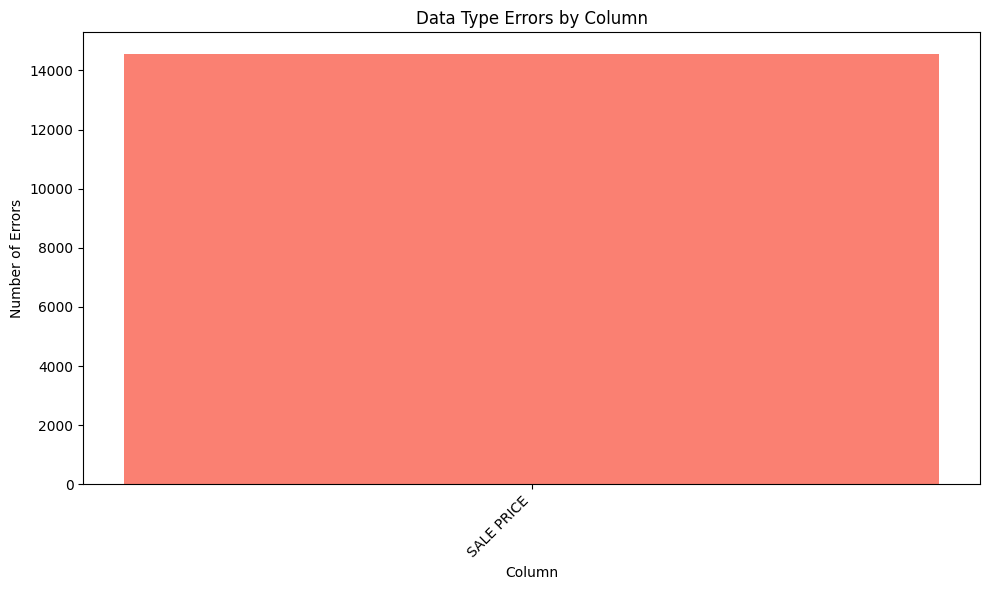

In [ ]:
# RESULT
print("Data Type Error Report:")
print("-" * 50)

if not data_type_errors:
    print("No data type errors found.")
else:
    for column, errors in data_type_errors.items():
        expected_type = columns_to_check[column]
        print(f"\nColumn '{column}' (expected type: {expected_type}):")
        print(f"Found {len(errors)} data type errors.")
        print("Examples:")
        for i, (idx, value) in enumerate(errors[:5]):  # Show first 5 examples
            print(f"  - Row {idx+1}: '{value}'")
        if len(errors) > 5:
            print(f"  - ... and {len(errors)-5} more errors.")
            
    # Create a bar chart of error counts
    error_counts = {column: len(errors) for column, errors in data_type_errors.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(error_counts.keys(), error_counts.values(), color='salmon')
    plt.title('Data Type Errors by Column')
    plt.xlabel('Column')
    plt.ylabel('Number of Errors')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Test 2: Range Errors
**Description:**  
This test verifies that numerical values fall within an acceptable range. For instance, the `SALE PRICE` should be between a defined minimum and maximum.

In [30]:
# PARAMETERS FOR THE CHECKER
# Please enter the attributes below
# List all columns to check with their min and max values
range_checks = {
    'BOROUGH': {'min': 1, 'max': 5},
    'SALE PRICE': {'min': 1, 'max': 100000000},  # $1 to $100 million
    'BLOCK': {'min': 1, 'max': 20000},
    'LOT': {'min': 1, 'max': 10000}
}

# Flag whether to include or exclude zeros
include_zeros = {
    'SALE PRICE': False,  # Exclude zero prices as they might represent transfers
    'BOROUGH': True,      # No zero boroughs
    'BLOCK': True,
    'LOT': True
}

In [31]:
# CHECKER CODE
def check_ranges(df, range_checks, include_zeros):
    """
    Check if numerical values in the dataframe fall within expected ranges.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to check
    range_checks : dict
        Dictionary with column names as keys and dictionaries of min/max values
    include_zeros : dict
        Dictionary indicating whether zeros should be included in the check
        
    Returns:
    --------
    dict
        A dictionary with column names as keys and lists of out-of-range rows
    """
    errors = {}
    
    for column, ranges in range_checks.items():
        if column not in df.columns:
            print(f"Warning: Column '{column}' not found in the dataframe.")
            continue
        
        min_val = ranges['min']
        max_val = ranges['max']
        include_zero = include_zeros.get(column, True)
        
        out_of_range_rows = []
        
        for idx, value in enumerate(df[column]):
            if pd.isna(value):
                continue
                
            # Convert to numeric value
            try:
                if isinstance(value, str):
                    value = value.replace('$', '').replace(',', '')
                num_value = float(value)
                
                # Check if value is out of range
                if not include_zero and num_value == 0:
                    continue
                if num_value < min_val or num_value > max_val:
                    out_of_range_rows.append((idx, num_value))
            except (ValueError, TypeError):
                continue
                
        if out_of_range_rows:
            errors[column] = out_of_range_rows
            
    return errors

# Run the checker
range_errors = check_ranges(df, range_checks, include_zeros)

In [38]:
#RESULT 
# Generate report
print("Range Error Report:")
print("-" * 50)

if not range_errors:
    print("No range errors found.")
else:
    for column, errors in range_errors.items():
        ranges = range_checks[column]
        print("There were various range errors found in the dataset, specifically from the 'SALE PRICE' column.")
        print(f"\nColumn '{column}' (expected range: {ranges['min']} to {ranges['max']}):")
        print(f"Found {len(errors)} range errors.")
        print("Examples:")
        for i, (idx, value) in enumerate(errors[:5]):  # Show first 5 examples
            print(f"  - Row {idx+1}: {value}")
        if len(errors) > 5:
            print(f"  - ... and {len(errors)-5} more errors.")


Range Error Report:
--------------------------------------------------
There were various range errors found in the dataset, specifically from the 'SALE PRICE' column.

Column 'SALE PRICE' (expected range: 1 to 100000000):
Found 48 range errors.
Examples:
  - Row 932: 150000000.0
  - Row 942: 107250000.0
  - Row 951: 139725000.0
  - Row 1123: 141500000.0
  - Row 2047: 108000000.0
  - ... and 43 more errors.


### Test 3: Format Errors
**Description:**  
This test validates that data follows a specified format. For example, the `SALE DATE` should follow the format `YYYY-MM-DD` and the `ADDRESS` should match a certain pattern.

In [39]:
# PARAMETERS FOR THE CHECKER
# Please enter the various attributes below to perform the test:
# List all columns to check with their expected format patterns
format_patterns = {
    'SALE DATE': r'^\d{1,2}/\d{1,2}/\d{4}$',  # MM/DD/YYYY format
    'BOROUGH': r'^[1-5]$',  # Single digit 1-5
    'BUILDING CLASS AT PRESENT': r'^[A-Z][0-9]$',  # Letter followed by a number
    'BUILDING CLASS AT TIME OF SALE': r'^[A-Z][0-9]$',  # Letter followed by a number
    'ZIP CODE': r'^\d{5}$'  # 5-digit zip code
}

# Number of rows to check (0 for all rows)
max_rows_to_check = 0  # Check all rows

In [41]:
# CHECKER CODE
def check_formats(df, format_patterns, max_rows_to_check=0):
    """
    Check if values in the dataframe match the expected format patterns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to check
    format_patterns : dict
        Dictionary with column names as keys and regex patterns as values
    max_rows_to_check : int
        Maximum number of rows to check (0 for all rows)
        
    Returns:
    --------
    dict
        A dictionary with column names as keys and lists of incorrectly formatted rows
    """
    errors = {}
    
    # Determine how many rows to check
    num_rows = len(df) if max_rows_to_check == 0 else min(max_rows_to_check, len(df))
    
    for column, pattern in format_patterns.items():
        if column not in df.columns:
            print(f"Warning: Column '{column}' not found in the dataframe.")
            continue
            
        format_errors = []
        
        for idx in range(num_rows):
            value = df.iloc[idx][column]
            if pd.isna(value):
                continue
                
            # Convert to string for regex matching
            str_value = str(value)
            
            # Check if value matches the pattern
            if not re.match(pattern, str_value):
                format_errors.append((idx, str_value))
                
        if format_errors:
            errors[column] = format_errors
            
    return errors

# Run the checker
format_errors = check_formats(df, format_patterns, max_rows_to_check)

Format Error Report:
--------------------------------------------------

Column 'SALE DATE' (expected format: ^\d{1,2}/\d{1,2}/\d{4}$):
Found 84548 format errors.
Examples:
  - Row 1: '2017-07-19 00:00:00'
  - Row 2: '2016-12-14 00:00:00'
  - Row 3: '2016-12-09 00:00:00'
  - Row 4: '2016-09-23 00:00:00'
  - Row 5: '2016-11-17 00:00:00'
  - ... and 84543 more errors.

Column 'BUILDING CLASS AT PRESENT' (expected format: ^[A-Z][0-9]$):
Found 3426 format errors.
Examples:
  - Row 74: 'RR'
  - Row 75: ' '
  - Row 76: 'RR'
  - Row 199: ' '
  - Row 200: 'RK'
  - ... and 3421 more errors.

Column 'BUILDING CLASS AT TIME OF SALE' (expected format: ^[A-Z][0-9]$):
Found 2818 format errors.
Examples:
  - Row 74: 'RR'
  - Row 75: 'RR'
  - Row 76: 'RR'
  - Row 199: 'RA'
  - Row 200: 'RK'
  - ... and 2813 more errors.

Column 'ZIP CODE' (expected format: ^\d{5}$):
Found 982 format errors.
Examples:
  - Row 75: '0'
  - Row 199: '0'
  - Row 576: '0'
  - Row 577: '0'
  - Row 721: '0'
  - ... and 977 mo

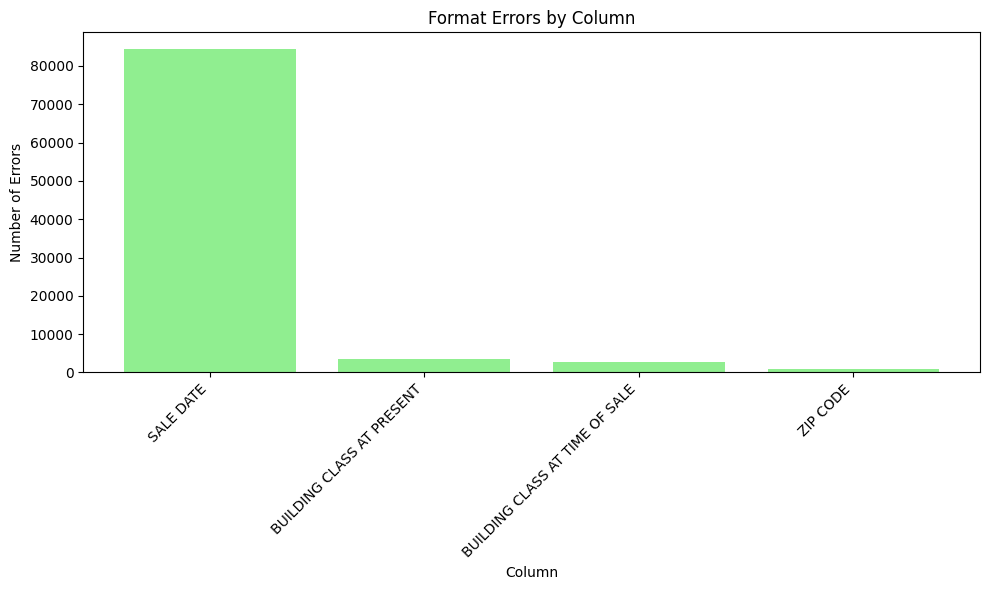

In [43]:
# RESULTS
# Generate report
print("Format Error Report:")
print("-" * 50)

if not format_errors:
    print("No format errors found.")
else:
    for column, errors in format_errors.items():
        pattern = format_patterns[column]
        print(f"\nColumn '{column}' (expected format: {pattern}):")
        print(f"Found {len(errors)} format errors.")
        print("Examples:")
        for i, (idx, value) in enumerate(errors[:5]):  # Show first 5 examples
            print(f"  - Row {idx+1}: '{value}'")
        if len(errors) > 5:
            print(f"  - ... and {len(errors)-5} more errors.")
            
    # Create a bar chart of error counts
    error_counts = {column: len(errors) for column, errors in format_errors.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(error_counts.keys(), error_counts.values(), color='lightgreen')
    plt.title('Format Errors by Column')
    plt.xlabel('Column')
    plt.ylabel('Number of Errors')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Test 4: Consistency Errors
**Description:**  
This test checks for conflicting or contradictory values. For instance, if the `BOROUGH` code does not align with known NYC boroughs or if related fields such as `BLOCK` and `LOT` are inconsistent.


In [52]:
# PARAMETERS FOR THE CHECKER
# Please enter the various attributes below to perform the test:
# Define pairs of columns that should be consistent with each other
consistency_checks = [
    {
        'columns': ['BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE'],
        'description': 'Building class at present should match building class at time of sale for recent sales',
        'condition': lambda row: pd.notna(row['SALE DATE']) and 
                                (pd.to_datetime(row['SALE DATE'], '%m/%d/%Y').year >= 2022),
        'error_message': 'Building class mismatch for recent sale'
    },
    {
        'columns': ['BOROUGH', 'NEIGHBORHOOD'],
        'description': 'Neighborhoods should be consistent with boroughs',
        'mappings': {
            1: ['ALPHABET CITY', 'BATTERY PARK', 'CHELSEA', 'CHINATOWN', 'EAST VILLAGE', 
                'FINANCIAL', 'FLATIRON', 'GRAMERCY', 'GREENWICH VILLAGE', 'HARLEM', 
                'INWOOD', 'LOWER EAST SIDE', 'MIDTOWN', 'MORNINGSIDE HEIGHTS', 
                'MURRAY HILL', 'SOHO', 'TRIBECA', 'UPPER EAST SIDE', 'UPPER WEST SIDE', 
                'WASHINGTON HEIGHTS', 'WEST VILLAGE'],
            2: ['BAYCHESTER', 'BEDFORD PARK', 'BELMONT', 'BRONX', 'CASTLE HILL', 
                'CITY ISLAND', 'CONCOURSE', 'FORDHAM', 'HIGHBRIDGE', 'HUNTS POINT', 
                'KINGSBRIDGE', 'MELROSE', 'MORRIS HEIGHTS', 'MORRIS PARK', 'MORRISANIA', 
                'MOTT HAVEN', 'PARKCHESTER', 'PELHAM BAY', 'RIVERDALE', 'SOUNDVIEW', 
                'THROGS NECK', 'TREMONT', 'UNIVERSITY HEIGHTS', 'WILLIAMSBRIDGE'],
            3: ['BAY RIDGE', 'BEDFORD STUYVESANT', 'BENSONHURST', 'BOROUGH PARK', 'BROWNSVILLE', 
                'BUSHWICK', 'CANARSIE', 'CARROLL GARDENS', 'CLINTON HILL', 'CONEY ISLAND', 
                'CROWN HEIGHTS', 'CYPRESS HILLS', 'DUMBO', 'EAST FLATBUSH', 'EAST NEW YORK', 
                'FLATBUSH', 'FLATLANDS', 'FORT GREENE', 'GOWANUS', 'GRAVESEND', 'GREENPOINT', 
                'MIDWOOD', 'PARK SLOPE', 'PROSPECT HEIGHTS', 'RED HOOK', 'SHEEPSHEAD BAY', 
                'SUNSET PARK', 'WILLIAMSBURG', 'WINDSOR TERRACE'],
            4: ['ASTORIA', 'BAYSIDE', 'CORONA', 'ELMHURST', 'FAR ROCKAWAY', 'FLUSHING', 
                'FOREST HILLS', 'FRESH MEADOWS', 'JAMAICA', 'KEW GARDENS', 'LONG ISLAND CITY', 
                'MASPETH', 'MIDDLE VILLAGE', 'OZONE PARK', 'QUEENS VILLAGE', 'REGO PARK', 
                'RICHMOND HILL', 'RIDGEWOOD', 'ROCKAWAY', 'SUNNYSIDE', 'WHITESTONE', 'WOODHAVEN', 
                'WOODSIDE'],
            5: ['ANNADALE', 'ARDEN HEIGHTS', 'ARROCHAR', 'BLOOMFIELD', 'BULLS HEAD', 
                'CHARLESTOWN', 'CLIFTON', 'DONGAN HILLS', 'ELTINGVILLE', 'GREAT KILLS', 
                'GRYMES HILL', 'HUGUENOT', 'MARINERS HARBOR', 'NEW DORP', 'PORT RICHMOND', 
                'PRINCES BAY', 'RICHMONDTOWN', 'ROSSVILLE', 'ST. GEORGE', 'STATEN ISLAND', 
                'TOMPKINSVILLE', 'TOTTENVILLE', 'WEST BRIGHTON', 'WESTERLEIGH']
        },
        'error_message': 'Neighborhood inconsistent with borough'
    }
]

In [53]:
# CHECKER CODE
def check_consistency(df, consistency_checks):
    """
    Check for consistency between related fields in the dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to check
    consistency_checks : list
        List of dictionaries defining consistency checks
        
    Returns:
    --------
    dict
        A dictionary with check descriptions as keys and lists of inconsistent rows
    """
    errors = {}
    
    for check in consistency_checks:
        columns = check['columns']
        description = check['description']
        
        # Verify columns exist in the dataframe
        if not all(column in df.columns for column in columns):
            missing_cols = [col for col in columns if col not in df.columns]
            print(f"Warning: Columns {missing_cols} not found in the dataframe.")
            continue
            
        inconsistent_rows = []
        
        # Check consistency based on check type
        if 'condition' in check:
            # Conditional consistency check
            condition = check['condition']
            for idx, row in df.iterrows():
                if condition(row):
                    if row[columns[0]] != row[columns[1]]:
                        inconsistent_rows.append((idx, row[columns[0]], row[columns[1]]))
                        
        elif 'mappings' in check:
            # Mapping-based consistency check
            mappings = check['mappings']
            for idx, row in df.iterrows():
                borough = row[columns[0]]
                neighborhood = row[columns[1]]
                
                if pd.isna(borough) or pd.isna(neighborhood):
                    continue
                
                try:
                    borough = int(borough)
                    if borough in mappings:
                        valid_neighborhoods = mappings[borough]
                        if neighborhood not in valid_neighborhoods:
                            inconsistent_rows.append((idx, borough, neighborhood))
                except (ValueError, TypeError):
                    # Skip non-numeric borough values
                    continue
        
        if inconsistent_rows:
            errors[description] = {
                'columns': columns,
                'error_message': check['error_message'],
                'rows': inconsistent_rows
            }
            
    return errors

# Run the checker
consistency_errors = check_consistency(df, consistency_checks)

Consistency Error Report:
--------------------------------------------------

Check: Neighborhoods should be consistent with boroughs
Columns involved: BOROUGH, NEIGHBORHOOD
Found 46024 consistency errors.
Examples:
  - Row 1127: BOROUGH='1', NEIGHBORHOOD='CIVIC CENTER' (Neighborhood inconsistent with borough)
  - Row 1128: BOROUGH='1', NEIGHBORHOOD='CIVIC CENTER' (Neighborhood inconsistent with borough)
  - Row 1129: BOROUGH='1', NEIGHBORHOOD='CIVIC CENTER' (Neighborhood inconsistent with borough)
  - Row 1130: BOROUGH='1', NEIGHBORHOOD='CIVIC CENTER' (Neighborhood inconsistent with borough)
  - Row 1131: BOROUGH='1', NEIGHBORHOOD='CIVIC CENTER' (Neighborhood inconsistent with borough)
  - ... and 46019 more errors.


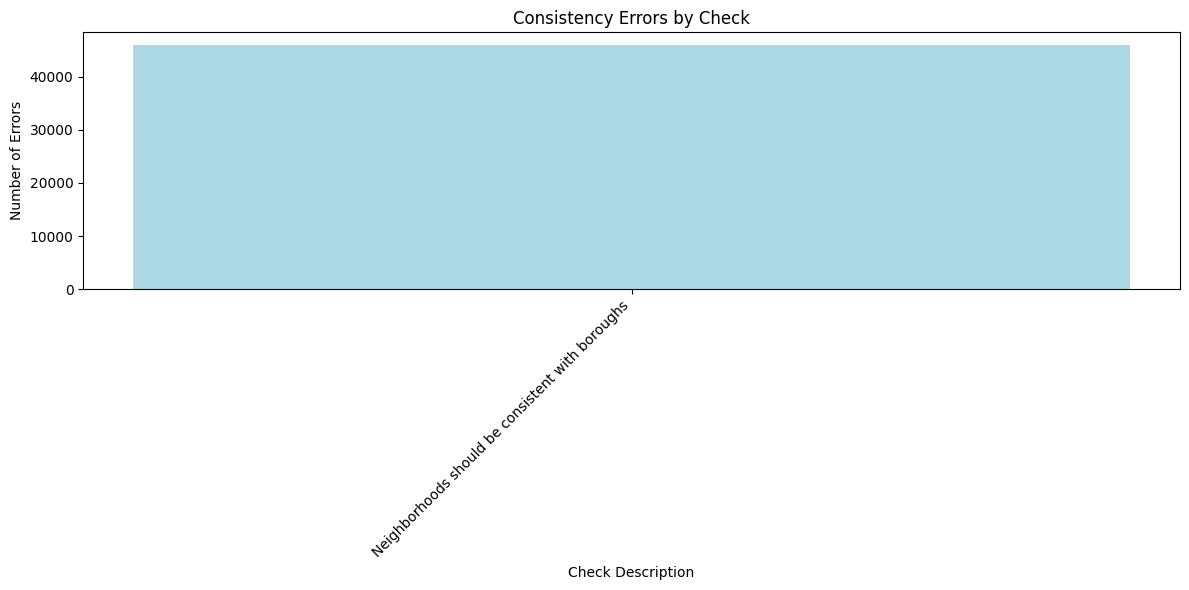

In [54]:
# RESULT
# Generate report
print("Consistency Error Report:")
print("-" * 50)

if not consistency_errors:
    print("No consistency errors found.")
else:
    for description, error_info in consistency_errors.items():
        columns = error_info['columns']
        error_message = error_info['error_message']
        inconsistent_rows = error_info['rows']
        
        print(f"\nCheck: {description}")
        print(f"Columns involved: {', '.join(columns)}")
        print(f"Found {len(inconsistent_rows)} consistency errors.")
        print("Examples:")
        for i, row_data in enumerate(inconsistent_rows[:5]):  # Show first 5 examples
            idx, val1, val2 = row_data
            print(f"  - Row {idx+1}: {columns[0]}='{val1}', {columns[1]}='{val2}' ({error_message})")
        if len(inconsistent_rows) > 5:
            print(f"  - ... and {len(inconsistent_rows)-5} more errors.")
    
    # Create a bar chart of error counts
    error_counts = {desc: len(info['rows']) for desc, info in consistency_errors.items()}
    plt.figure(figsize=(12, 6))
    plt.bar(error_counts.keys(), error_counts.values(), color='lightblue')
    plt.title('Consistency Errors by Check')
    plt.xlabel('Check Description')
    plt.ylabel('Number of Errors')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()